## Demo 6: Molecule in a Box (a.k.a. Poor man's molecule)

### Introduction

In this in-class iPython notebook, we'll learn how to work with a matrix representation of the Hamiltonian operator, $\hat{H}$.  We'll use this to get the eigenfunctions and eigenvalues (i.e. the energies) of $\hat{H}$ for a potential $V(x)$ that will serve as a simple representation of a molecule with two nuclei and a single electron (e.g. $H_2^+$). 

We'll **review** some of the stuff you've learned so far : 

1. Creating and using functions in ipython.

And we'll play around with some **new concepts** :

1. Matrix representation of a Hamiltonian.
2. Finding eigenvalues and eigenvectors of a matrix with numpy.
3. Degenerate energy levels.

## Before you start ...

Remember our conventions:
1. <i class="fa fa-book"></i> means you only need to read an execute the boxes.
2. <i class="fa fa-wrench"></i> means you need also to complete code, indicated by instructions in capital letters.
3. <i class="fa fa-gear"></i> means there is question you should answer based on the results you've obtained so far. Stop coding and start theorizing!


### Have fun!

### <i class="fa fa-book"></i> Step 1: Import the set of modules and functions that we'll be using

We are going to make extensive use of our ipython library (qworld) in this demo.

In [1]:
% pylab inline
import numpy as np
from matplotlib import pyplot as plt
#Now we'll import a module that let's us specify that path to our Chem160_library, and import it as a module
import imp
#This is how we'll import our own homemade modules
qworld = imp.load_source('qworld', '../library/quantumWorld.py')

Populating the interactive namespace from numpy and matplotlib


###  <i class="fa fa-wrench"></i> Step 2:  Let's write a function that generates a potential that mimics a diatomic molecule.

A diatomic molecule comprises two nuclei, that can be represented a two positive point charges, and a given number of electrons. The electrostatic attraction between electrons and nuclei is the fundamental force that estabilizes atoms and molecules. Later in the course we will see in detail how to solve the Schrodinger equation for a diatomic system. For now we will mimic the basic structure of a homonuclear diatomic molecule using a simple potential with two finite square wells, that partially recreates the atractive potential experienced by electrons in these systems.

The next function generates such a potential, check it out and take note of the parameters that describe the potential.

In [2]:
def box_with_barrier_V(x, R, r, r_pad, D):
    '''Builds a box with barrier potential, V_x
    inputs:
        --> x -- array of positions
        --> R -- Length of barrier
        --> r -- length of the wells
        --> r_pad -- length of regions that "pad" the wells at the boundaries
        --> D -- height of barrier
    '''
    L = R + 2*r + 2*r_pad  #This is the length of the entire box. 
    V_x = np.zeros_like(x) #initialize V_x as an array of zeros. 
    for i in range(len(x)):
        #Let's build it in a piece-wise manner. 
        if x[i] < 0 or x[i] > L:
            print 'error, values of x must be between 0 and L'
            return None
        elif x[i] <= r_pad:  # x is between 0 and r
            V_x[i] = 0
        elif x[i] <= r_pad + r: # x is between 0 and r
            V_x[i] = -D
        elif x[i] <= r_pad + r + R:
            V_x[i] = 0
        elif x[i] <= r_pad + 2*r + R:
            V_x[i] = -D
        elif x[i] <= 2*r_pad + 2*r + R : # x is between 0 and r
            V_x[i] = 0
    return V_x

Now let's see how this potential looks like.

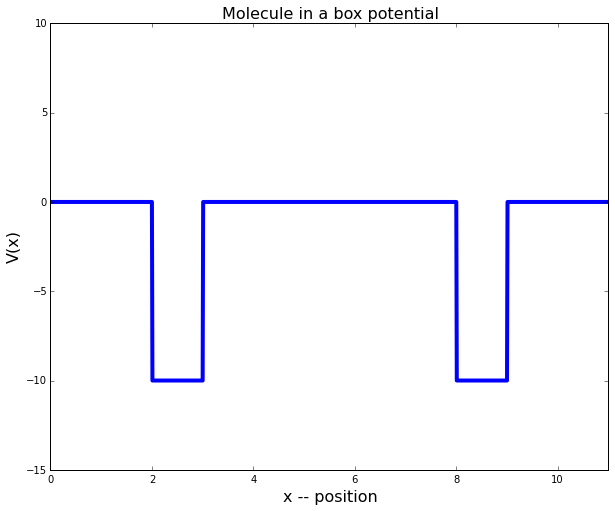

In [3]:
D = 10 #the height of the barrier
R = 5 # the width of the barrier, 
r = 1 # the width of the wells
r_pad = 2 # the width of the boundary regions that "pad" the wells,
L = R + 2*r + 2*r_pad # the width of the entire box. 

#An array of positions
x = np.arange(0,L,0.01) 

########(ONE LINE) CALL THE FUNCTION WE CREATED ABOVE TO GENERATE THE POTENTIAL
# assigning it to the variable Vx 
Vx = box_with_barrier_V(x, R, r, r_pad, D)
#############


#Let's plot!
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 8)
plt.plot(x, Vx, linewidth = 4)
#Some plot parameters
plt.axis((0,L,-(D+5), 10))
plt.xlabel('x -- position', fontsize = 16)
plt.ylabel('V(x)', fontsize = 16)
plt.title('Molecule in a box potential', fontsize = 16)
plt.show()

### <i class="fa fa-gear"></i> Identify in the previous plot which features correspond to the parameters D, R and r. What would be the positions of the nuclei in our model? Discuss it with your partners.

### <i class="fa fa-wrench"></i> Step 3: Write a function to generate the matrix representation of the Hamiltonian.

We saw in class today that the H matrix has the following structure <br> <br>
$$ H = \left( \begin{array}{ccccc}
2t+V_1 & -t & 0 & 0 & ... \\
-t & 2t+V_2 & -t & 0 & ... \\
0 & -t & 2t+V_3 & - t & ... \\
.. & .. & .. & .. & ..  \end{array} \right)$$ <br> <br>
where $t = \frac{\hbar^2}{2 m a^2}$, and $a$ is the spacing of the grid. We will write a function that, given an array x and a potential V_x, defined over x, returns the Hamiltonian matrix associated to the discretized potential.

In [4]:
def build_H_matrix(x, V_x, m = 1, h_bar = 1):
    ''' this function builds the matrix representation of H, 
    given x, the position array, and V_x as input
    '''
    a = x[1] - x[0] #x is the dx of the grid.  We can get it by taking the diff of the first two 
                    #entries in x
    t = h_bar**2 / (2 * m * a**2) # the parameter t, as defined by schrier
    
    # initialize H_matrix as a matrix of zeros, with appropriate size. 
    H_matrix = np.zeros((len(V_x), len(V_x)))   
    for i in range(len(V_x)): #Start adding the appropriate elements to the matrix
        
        ########(ONE LINE) ASSIGN TO THE H_matrix[i][i], THE DIAGONAL ELEMENTS OF H
        H_matrix[i][i] = 2*t + V_x[i]
        #########
        
        #special case, first row of H
        if i == 0: 
            #Assignt to H_matrix[i][i+1],the off-diagonal elements of H
            #The appropriate values, for the first row  
            H_matrix[i][i+1] = -t
        elif i == len(V_x) - 1: #special case, last row of H
            H_matrix[i][i-1] = -t
        else:  # for all the other rows
            ########(TWO LINES) ASSIGNT TO H_matrix[i][i+1] AND H_matrix[i][i-1]
            #(THE OFF-DIAGONAL ELEMENTS OF H) THE APPROPRIATE VALUE          
            H_matrix[i][i+1] = -t
            H_matrix[i][i-1] = -t
            ################
    return H_matrix

### <i class="fa fa-book"></i> Step 4: Finding the eigenfunctions of the hamiltonian for large barrier widths.

Now that we have the matrix-representation of $\hat{H}$, we can solve the time-independent Schrodinger equation $\hat{H}\psi(x) = E\psi(x)$ by asking numpy to find the eigenvalues and eigenvectors/eigenfunctions of $\hat{H}$. We can do this using the **eig** function that can be found in the **numpy.linalg** module

In [5]:
from numpy.linalg import eig

** Read the following code carefully, as you will need to understand it to complete the rest of the demo. **

value
[-7.70536967 -7.70536461 -7.7053655  ..., -7.7053784  -7.7053481
 -7.70538258]
[ -1.57688533e-05  -3.15620075e-05  -4.74038011e-05 ...,  -6.55927680e-06
  -4.36724354e-06  -2.18194050e-06]


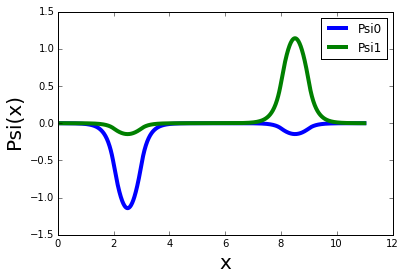

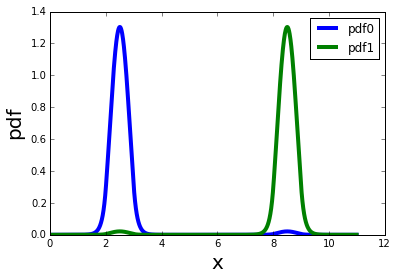

In [8]:
R = 5 #Width of barrier

D = 10 #height of barrier
r = 1 #width of the two wells. 
r_pad = 2 #with of the "padding" region to the left of the wells
L = R + 2*r + 2*r_pad #Total size of the box. 

#array of positions
x = np.arange(0, L, 0.01) 
#Construct the potential
V_x = box_with_barrier_V(x, R, r, r_pad, D) 

# Using the potential and the build_H_matrix function defined above, 
# we can build the H matrix, assigned to H
H = build_H_matrix(x, V_x) 

#using the eig function from numpy.linalg, get eigenvectors 
# and eigenfunctions.  Assign output to eigenvalues, and eigenvectors
#READ THE DOCUMENTATION OF eig TO GET A SENSE OF THE OUTPUTS
eigenvalues, eigenvectors = eig(H)

#Next, we use the numpy.argsort function to 
#sort the eigenvalues and get the indices of the 
#sorted eigenvalues
sort_index = numpy.argsort(eigenvalues)
ind1 = sort_index[0] #index of the lowest energy eigenvalue
ind2 = sort_index[1] #index of the second lowest one

#and we use these indices to plot the eigenfunctions associated to them
plt.figure()
psi0 = eigenvectors[:,ind1]
psi1 = eigenvectors[:,ind2]

psi0 = qworld.normalize_wf(x, psi0)
psi1 = qworld.normalize_wf(x, psi1)

plt.plot(x, psi0, linewidth = 4) #lowest energy
plt.plot(x, psi1, linewidth = 4) #next lowest energy
plt.xlabel('x', fontsize = 20)
plt.ylabel('Psi(x)', fontsize = 20)
plt.legend({'Psi0', 'Psi1'})

#and in a different figure, we use these indices to plot the 
#pdfs associated to these eigenfunctions
plt.figure()
pdf_0 = qworld.probabilityDensity(psi0)
pdf_1 = qworld.probabilityDensity(psi1)

print 'value'
print np.dot(H,psi0)/psi0

print psi0

plt.plot(x, pdf_0, linewidth = 4)
plt.plot(x, pdf_1, linewidth = 4)

plt.xlabel('x', fontsize = 20)
plt.ylabel('pdf', fontsize = 20)
plt.legend({'pdf0', 'pdf1'})

### <i class="fa fa-gear"></i> Question: Do the two eigenfunctions look like they're localized in each of the wells or not?

### <i class="fa fa-wrench"></i> Step 5: Finding the eigenfunctions of the hamiltonian for a smaller barrier width.

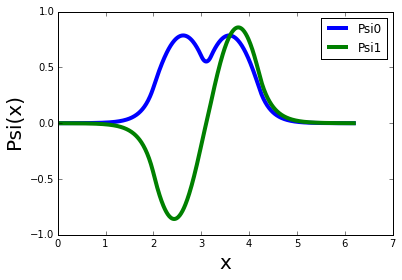

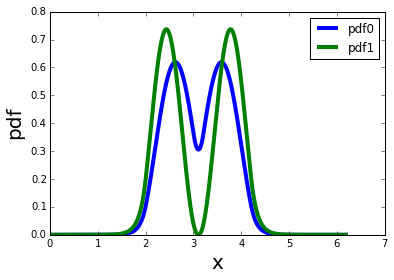

In [9]:
R = 0.2

D = 10 #height of barrier
r = 1 #width of the two wells. 
r_pad = 2 #with of the "padding" region to the left of the wells
L = R + 2*r + 2*r_pad #Total size of the box. 

x = np.arange(0, L, 0.01) #array of positions

##### (ONE LINE) USING THE box_with_barrier_V FUNCTION, GENERATE THE POTENTIAL
V_x = box_with_barrier_V(x, R, r, r_pad, D) 
################################################################################


##### (ONE LINE) USING THE build_H_matrix FUNCTION, GENERATE THE MATRIX FOR THE HAMILTONIAN (H)
H = build_H_matrix(x, V_x) 
##############################################################################################

##### (ONE LINE) NOW USING THE eig FUNCTION FROM NUMPY, CALCULATE THE EIGENVECTORS 
# AND EIGENVALUES OF THE MATRIX H
eigenvalues, eigenvectors = eig(H)
####################################################################################

#Next, we use the numpy.argsort function to 
#sort the eigenvalues and get the indices of the 
#sorted eigenvalues
sort_index = numpy.argsort(eigenvalues)
ind1 = sort_index[0]
ind2 = sort_index[1]

#and we use these indices to plot the eigenvectors associated to them
plt.figure()
psi0 = eigenvectors[:,ind1]
psi1 = eigenvectors[:,ind2]
psi0 = qworld.normalize_wf(x, psi0)
psi1 = qworld.normalize_wf(x, psi1)

plt.plot(x, psi0, linewidth = 4) #lowest energy
plt.plot(x, psi1, linewidth = 4) #next lowest energy
plt.xlabel('x', fontsize = 20)
plt.ylabel('Psi(x)', fontsize = 20)
plt.legend({'Psi0', 'Psi1'})

#and in a different figure, we use these indices to plot the 
#pdfs associated to these eigenfunctions
plt.figure()
pdf_0 = qworld.probabilityDensity(psi0)
pdf_1 = qworld.probabilityDensity(psi1)

plt.plot(x, pdf_0, linewidth = 4)
plt.plot(x, pdf_1, linewidth = 4)

plt.xlabel('x', fontsize = 20)
plt.ylabel('pdf', fontsize = 20)
plt.legend({'pdf0', 'pdf1'})
plt.show()

### <i class="fa fa-gear"></i> Question: What do the eigenfunctions look like for small barrier widths? Do the two eigenfunctions look like they're localized in each of the wells or not?

### <i class="fa fa-gear"></i> Question: Can you tell which is the bonding and which is the anti-bonding wavefunction? 

###  <i class="fa fa-wrench"></i> Step 6: Analyzing the energy splitting for different values of the barrier width.

What if we now vary the value of R, the width of the barrier, from R = 3 (relatively wide barrier) to R = 0, (no barrier).  And for each value of R, we'll get the two lowest energy eigenvalues. We'll first build the array of values of R, for which we'll obtain the eigenvalues for.

In [10]:
R1 = np.arange(3, 1, -1)
R2 = np.arange(1.9, 0, -0.1)
Rarray = np.concatenate((R1, R2), axis = 1)
print 'We are going to scan the two lowest energy eigenvalues for these values of barrier width:'
print Rarray

We are going to scan the two lowest energy eigenvalues for these values of barrier width:
[ 3.   2.   1.9  1.8  1.7  1.6  1.5  1.4  1.3  1.2  1.1  1.   0.9  0.8  0.7
  0.6  0.5  0.4  0.3  0.2  0.1]


In [11]:
D = 10 #height of barrier
r = 1 #width of the two wells. 
r_pad = 2 #with of the "padding" region to the left of the wells

E_1 = [] #two empty lists, where we'll store the lowest energy eigenvallues
E_2 = []


for R in Rarray:
    print 'Obtaining the eigenvalues of H for R = ', R
    L = R + 2*r + 2*r_pad
    #build array of positions
    x = np.arange(0, L, 0.01)
    #Build the potential V(x)
    V_x = box_with_barrier_V(x, R, r, r_pad, D)
    #build the H matrix
    H = build_H_matrix(x, V_x)
    
    ########(ONE LINE) USE THE EIG FUNCTION TO GET THE EIGENVALUES AND EIGENVECTORS
    #Assing output to eigenvalues, eigenvectors variables
    eigenvalues, eigenvectors = eig(H)
    ###########
   
    #This is how we'll sort the eigenvalues
    #from lowest to highest energy
    sort_index = numpy.argsort(eigenvalues)

    #we append to E_1 the lowest energy
    E_1.append(eigenvalues[sort_index[0]]) 
    #we append to E_2 the 2nd lowest energy
    E_2.append(eigenvalues[sort_index[1]]) 

Obtaining the eigenvalues of H for R =  3.0
Obtaining the eigenvalues of H for R =  2.0
Obtaining the eigenvalues of H for R =  1.9
Obtaining the eigenvalues of H for R =  1.8
Obtaining the eigenvalues of H for R =  1.7
Obtaining the eigenvalues of H for R =  1.6
Obtaining the eigenvalues of H for R =  1.5
Obtaining the eigenvalues of H for R =  1.4
Obtaining the eigenvalues of H for R =  1.3
Obtaining the eigenvalues of H for R =  1.2
Obtaining the eigenvalues of H for R =  1.1
Obtaining the eigenvalues of H for R =  1.0
Obtaining the eigenvalues of H for R =  0.9
Obtaining the eigenvalues of H for R =  0.8
Obtaining the eigenvalues of H for R =  0.7
Obtaining the eigenvalues of H for R =  0.6
Obtaining the eigenvalues of H for R =  0.5
Obtaining the eigenvalues of H for R =  0.4
Obtaining the eigenvalues of H for R =  0.3
Obtaining the eigenvalues of H for R =  0.2
Obtaining the eigenvalues of H for R =  0.1


Now let's plot the two lowest eigenvalues as a function of the barrier width. ** Use the function my_plotting_function you used in the last demo**. It is now included in our qworld library. If you don't remember the instructions, use help.

Help on function my_plotting_function in module qworld:

my_plotting_function(x, functions_list, labels_list, title='Plot', xlab='x', ylab='f(x)', fts=12, lw=2, fs=(10, 8))



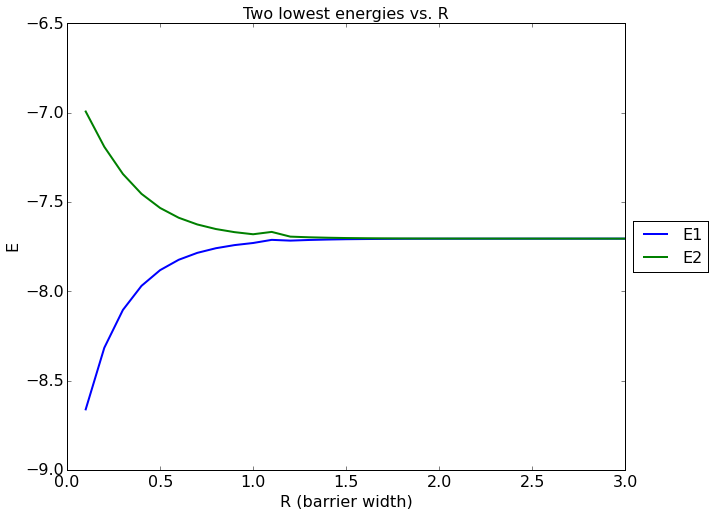

In [12]:
help(qworld.my_plotting_function)

# (ONE LINE) CALL my_plotting_function TO PLOT THE VALUES OF E1 AND E2 AS A FUNCTION OF R
qworld.my_plotting_function(Rarray, [E_1, E_2],['E1', 'E2'],title='Two lowest energies vs. R', xlab='R (barrier width)', ylab='E',fts=16)


### <i class="fa fa-gear"></i> Question: How does the splitting of the energies change as the barrier width gets smaller? 

### <i class="fa fa-gear"></i> Question: In a molecule, what would the gap between E1 and E2 correspond to?


## <i class="fa fa-book"></i> Step 7. What did you learn in this demo?

### 1. How to use the finite difference method to solve the Schrodinger equation in a matrix representation.

### 2. How to find eigenvectors and eigenfunctions of a matrix using numpy.

### 3. The connection between the form of a double squared potential and the localization of the wavefunction.

### 4. The connection between the form of a double squared potential and the degeneracy of the eigenvalues.